# TechLab - Portfolio Optimization Pt.3

Nel terzo laboratorio applicheremo un'ottimizzazione di portafoglio attraverso l'uso di una rete neurale seguendo quattro fasi:
1. Download e preparazione dei dati
2. Definition della rete neurale
3. Addestramento
4. Valutazione e visualizzazione dei risultati

In [1]:
%matplotlib inline
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy
import matplotlib.pyplot as plt
import numpy as np
import torch
import datetime
import pandas as pd
import pandas_datareader.data as web

Al fine di rendere i risultati riproducibili fissiamo il seed per :code:`numpy` e :code:`torch`.

In [2]:
torch.manual_seed(4)
np.random.seed(5)

## Caricamento del dataset


In [3]:
start = datetime.datetime(2015, 1, 1) 
end = datetime.datetime(2020, 12, 31)

tickers = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
raw_df = web.DataReader(tickers, 'yahoo', start=start, end=end)[['Adj Close']]

In [4]:
raw_df.columns = pd.MultiIndex.from_product([['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG'], ['Adj Close']], names=['Ticker', 'Attribute'])

In [5]:
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)

In [6]:
n_timesteps = len(raw_df)  
n_channels = len(raw_df.columns.levels[1])  
n_assets = len(raw_df.columns.levels[0])

In [7]:
print('Timesteps = '+ str(n_timesteps))
print('Channels = '+ str(n_channels))
print('Assets = '+ str(n_assets))

Timesteps = 1511
Channels = 1
Assets = 5


In [8]:
lookback, gap, horizon = 50, 0, 25

In [9]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(raw_df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon)

In [10]:
n_samples = n_timesteps - lookback - horizon - gap 
n_samples

1436

In [11]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:1147
Test range: 1223:1435


We can now construct the :code:`InRAMDataset`. By providing the optional :code:`transform` we
make sure that when the samples are streamed they are always scaled based on our computed
(training) statistics. See `inramdataset` for more details.



In [12]:
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

X_sample, y_sample, timestamp_sample, asset_names = dataset[0]

Using the :code:`dataset` we can now construct two dataloaders—one for training and the other one
for testing. For more details see `dataloaders`.



In [13]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

## Network definition
Let us now write a custom network. See `writing_custom_networks`.



In [14]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

So what is this network doing? First of all, we make an assumption that assets and lookback will
never change (the same shape and order at train and at inference time). This assumption
is justified since we are using :code:`RigidDataLoader`.
We can learn :code:`n_assets` linear models that have :code:`n_assets * lookback` features. In
other words we have a dense layer that takes the flattened feature tensor :code:`x` and returns
a vector of length :code:`n_assets`. Since elements of this vector can range from $-\infty$
to $\infty$ we turn it into an asset allocation via :code:`SoftmaxAllocator`.
Additionally, we learn the :code:`temperature` from the data. This will enable us to learn the
optimal trade-off between an equally weighted allocation (uniform distribution) and
single asset portfolios.



In [15]:
network = GreatNet(n_assets, lookback)
print(network)

GreatNet(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (dense_layer): Linear(in_features=250, out_features=5, bias=True)
  (allocate_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In :code:`torch` networks are either in the **train** or **eval** mode. Since we are using
dropout it is essential that we set the mode correctly based on what we are trying to do.



In [16]:
network = network.train()  # it is the default, however, just to make the distinction clear

## Training
It is now time to define our loss. Let's say we want to achieve multiple objectives at the same
time. We want to minimize the drawdowns, maximize the mean returns and also maximize the Sharpe
ratio. All of these losses are implemented in :code:`deepdow.losses`. To avoid confusion, they
are always implemented in a way that **the lower the value of the loss the better**. To combine
multiple objectives we can simply sum all of the individual losses. Similarly, if we want to
assign more importance to one of them we can achieve this by multiplying by a constant. To learn
more see `losses`.



In [17]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()

Note that by default all the losses assume that we input logarithmic returns
(:code:`input_type='log'`) and that they are in the 0th channel (:code:`returns_channel=0`).



We now have all the ingredients ready for training of the neural network. :code:`deepdow` implements
a simple wrapper :code:`Run` that implements the training loop and a minimal callback
framework. For further information see `experiments`.



In [18]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

To run the training loop, we use the :code:`launch` where we specify the number of epochs.



In [19]:
history = run.launch(30)

Epoch 0:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
Epoch 29: 100%|██████████| 36/36 [00:00<00:00, 84.80it/s, loss=-0.08207, test_loss=-0.11503]


## Evaluation and visualization
The :code:`history` object returned by :code:`launch` contains a lot of useful information related
to training. Specifically, the property :code:`metrics` returns a comprehensive :code:`pd.DataFrame`.
To display the average test loss per each epoch we can run following.



In [20]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        213
                             1        213
                             2        213
                             3        213
                             4        213
                             5        213
                             6        213
                             7        213
                             8        213
                             9        213
                             10       213
                             11       213
                             12       213
                             13       213
                             14       213
                             15       213
                             16       213
                             17       213
                             18       213
                             19       213
                             20       213
                             21       213
                             22       213

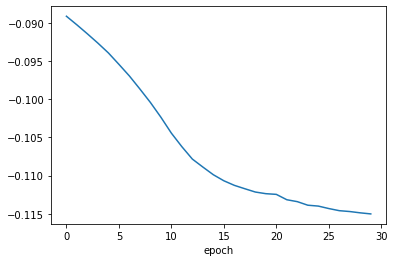

In [21]:
per_epoch_results.mean()['test']['loss']['network'].plot()

To get more insight into what our network predicts we can use the :code:`deepdow.visualize` module.
Before we even start further evaluations, let us make sure the network is in eval model.



In [22]:
network = network.eval()

To put the performance of our network in context, we also utilize benchmarks. :code:`deepdow`
offers multiple benchmarks already. Additionally, one can provide custom simple benchmarks or
some pre-trained networks.



In [23]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}

During training, the only mandatory metric/loss was the loss criterion that we tried to minimize.
Naturally, one might be interested in many other metrics to evaluate the performance. See below
an example.



In [24]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

Let us now use the above created objects. We first generate a table with all metrics over all
samples and for all benchmarks. This is done via :code:`generate_metrics_table`.



In [25]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics)

And then we plot it with :code:`plot_metrics`.



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f63f6d289a0>,
      dtype=object)

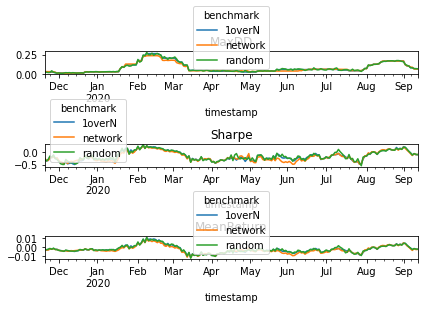

In [26]:
plot_metrics(metrics_table)

Each plot represents a different metric. The x-axis represents the timestamps in our
test set. The different colors are capturing different models. How is the value of a metric
computed? We assume that the investor predicts the portfolio at time x and buys it. He then
holds it for :code:`horizon` timesteps. The actual metric is then computed over this time horizon.



Finally, we are also interested in how the allocation/prediction looks like at each time step.
We can use the :code:`generate_weights_table` function to create a :code:`pd.DataFrame`.



In [27]:
weight_table = generate_weights_table(network, dataloader_test)

We then call the :code:`plot_weight_heatmap` to see a heatmap of weights.



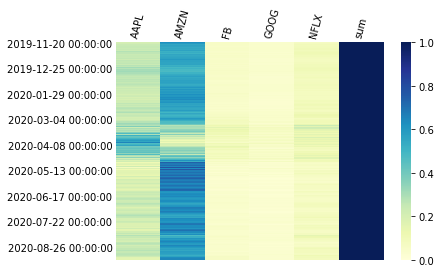

In [28]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

The rows represent different timesteps in our test set. The columns are all the assets in our
universe. The values represent the weight in the portfolio. Additionally, we add a sum column
to show that we are really generating valid allocations.

